## Outline


*   Recap of data
*   Feedforward network with Pytorch tensors and autograd
*   Using Pytorch's NN -> Functional, Linear, Sequential and PyTorch's Optim
*   Moving things to CUDA



In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss # log_loss => cross_entropy
from tqdm import tqdm_notebook
import seaborn as sns
import time
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import torch
torch.manual_seed(0)

In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["red", "yellow", "green"])

# Generate Dataset

In [4]:
data, labels = make_blobs(n_samples=1000, n_features=2, centers=4, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


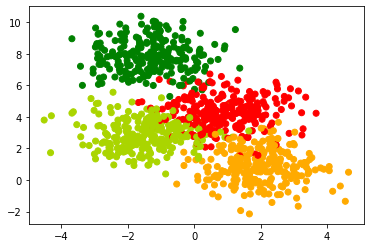

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape, labels.shape)

(750, 2) (250, 2) (1000,)


# Using torch tensors and autograd

In [0]:
# map to efficiently convert numpy vectors to Torch tensors
X_train, Y_train, X_val, Y_val = map(torch.tensor, [X_train, Y_train, X_val, Y_val])

In [8]:
print(X_train.shape, Y_train.shape)

torch.Size([750, 2]) torch.Size([750])


In [0]:
# Forward propagation of feed forward class
def model(x):
  # a1 is the a of all the neurons of 1st layer
  a1 = torch.matmul(x, weights1)+bias1 # (N,2) x (2,2) -> (N,2) [matmul=>normal multiplication]
  h1 = a1.sigmoid()
  a2 = torch.matmul(h1, weights2)+bias2 # (N,2) x (2,4) -> (N,4) [(#input, #output)]
  h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1) # softmax 
  return h2 # (N,4)

In [0]:
# Cross entropy loss
def loss_fn(y_hat, y):
  return -(y_hat[range(y.shape[0]), y].log()).mean()

In [0]:
def accuracy(pred,y):
  y_hat = torch.argmax(pred, dim=1)
  return(y_hat == y).float().mean()

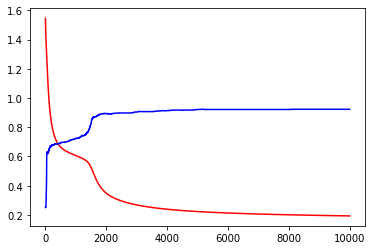

Loss before training 1.5456440448760986


In [12]:
torch.manual_seed(0)
weights1 = torch.randn(2,2)/math.sqrt(2)
weights1.requires_grad_()
weights2 = torch.randn(2,4)/math.sqrt(2)
weights2.requires_grad_()
bias1 = torch.zeros(2, requires_grad=True)
bias2 = torch.zeros(4, requires_grad=True)

learning_rate = 0.2
epochs = 10000

X_train = X_train.float()
Y_train = Y_train.long()

loss_arr = []
acc_arr = []

for epoch in range(epochs):
  y_hat = model(X_train)
  loss = loss_fn(y_hat, Y_train)
  loss.backward()
  loss_arr.append(loss.item())
  acc_arr.append(accuracy(y_hat, Y_train))

  with torch.no_grad(): # remember
    weights1 -= weights1.grad * learning_rate
    weights2 -= weights2.grad * learning_rate
    bias1 -= bias1.grad * learning_rate
    bias2 -= bias2.grad * learning_rate
    weights1.grad.zero_()
    weights2.grad.zero_()
    bias1.grad.zero_()
    bias2.grad.zero_()    

plt.plot(loss_arr, 'r-')
plt.plot(acc_arr, 'b-')
plt.show()
print("Loss before training", loss_arr[0])

# Using NN.Functional

In [0]:
import torch.nn.functional as F

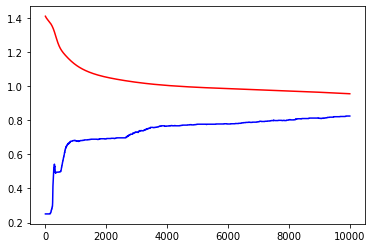

Loss before training 1.4111980199813843


In [14]:
torch.manual_seed(0)
weights1 = torch.randn(2,2)/math.sqrt(2)
weights1.requires_grad_()
weights2 = torch.randn(2,4)/math.sqrt(2)
weights2.requires_grad_()
bias1 = torch.zeros(2, requires_grad=True)
bias2 = torch.zeros(4, requires_grad=True)

learning_rate = 0.2
epochs = 10000

X_train = X_train.float()
Y_train = Y_train.long()

loss_arr = []
acc_arr = []

for epoch in range(epochs):
  y_hat = model(X_train)
  loss = F.cross_entropy(y_hat, Y_train) # Only change
  loss.backward()
  loss_arr.append(loss.item())
  acc_arr.append(accuracy(y_hat, Y_train))

  with torch.no_grad():
    weights1 -= weights1.grad * learning_rate
    weights2 -= weights2.grad * learning_rate
    bias1 -= bias1.grad * learning_rate
    bias2 -= bias2.grad * learning_rate
    weights1.grad.zero_()
    weights2.grad.zero_()
    bias1.grad.zero_()
    bias2.grad.zero_()    

plt.plot(loss_arr, 'r-')
plt.plot(acc_arr, 'b-')
plt.show()
print("Loss before training", loss_arr[0])

# Using NN.Parameter

In [0]:
import torch.nn as nn

In [0]:
class FirstNetwork(nn.Module):

  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.weights1 = nn.Parameter(torch.randn(2,2)/math.sqrt(2))
    self.weights2 = nn.Parameter(torch.randn(2,4)/math.sqrt(2))
    self.bias1 = nn.Parameter(torch.zeros(2, requires_grad=True))
    self.bias2 = nn.Parameter(torch.zeros(4, requires_grad=True))

  def forward(self, X):
    a1 = torch.matmul(X, self.weights1)+self.bias1
    h1 = a1.sigmoid()
    a2 = torch.matmul(h1, self.weights2)+self.bias2
    h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
    return h2

In [0]:
def fit(epochs = 1000, learning_rate = 1):
  loss_arr = []
  acc_arr = []
  for epoch in range(epochs):
    y_hat = fn(X_train)
    loss = F.cross_entropy(y_hat, Y_train)
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat, Y_train))

    loss.backward()
    with torch.no_grad(): # remember
      for param in fn.parameters():
        param -= learning_rate*param.grad
      fn.zero_grad()   

  plt.plot(loss_arr, 'r-')
  plt.plot(acc_arr, 'b-')
  plt.show()
  print("Loss before training", loss_arr[0])
  print("Loss after training", loss_arr[-1])

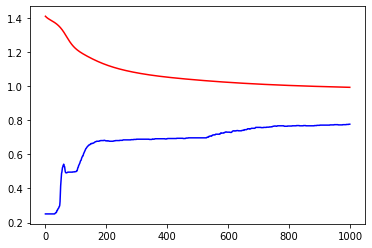

Loss before training 1.4111980199813843
Loss after training 0.9939236044883728


In [18]:
fn = FirstNetwork()
fit()

# Using NN.Linear and Optim

In [0]:
class FirstNetwork_v1(nn.Module):

  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.lin1 = nn.Linear(2,2)
    self.lin2 = nn.Linear(2,4)

  def forward(self, X):
    a1 = self.lin1(X)
    h1 = a1.sigmoid()
    a2 = self.lin2(h1)
    h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
    return h2

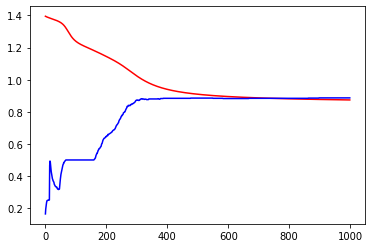

Loss before training 1.395160436630249
Loss after training 0.8738410472869873


In [20]:
fn = FirstNetwork_v1()
fit()

In [0]:
from torch import optim

In [0]:
def fit_v1(epochs = 1000, learning_rate=1):
  loss_arr = []
  acc_arr = []
  opt = optim.SGD(fn.parameters(), lr = learning_rate)

  for epoch in range(epochs):
    y_hat = fn(X_train)
    loss = F.cross_entropy(y_hat, Y_train)
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat, Y_train))

    loss.backward()
    opt.step()
    opt.zero_grad()

  plt.plot(loss_arr, 'r-')
  plt.plot(acc_arr, 'b-')
  plt.show()
  print("Loss before training", loss_arr[0])
  print("Loss after training", loss_arr[-1])

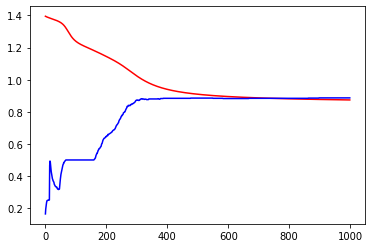

Loss before training 1.395160436630249
Loss after training 0.8738410472869873


In [23]:
fn = FirstNetwork_v1()
fit_v1()

Exactly same accuracy as before

# Using NN.Sequential

In [0]:
class FirstNetwork_v2(nn.Module):

  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    # All the linear transformation the input goes throught
    self.net = nn.Sequential(
        nn.Linear(2,2),
        nn.Sigmoid(),
        nn.Linear(2,4),
        nn.Softmax()
    )

  def forward(self, X):
    return self.net(X)

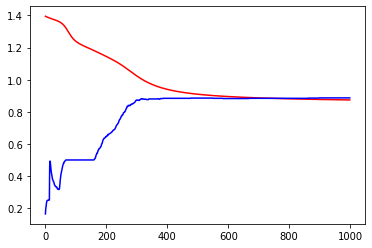

Loss before training 1.395160436630249
Loss after training 0.8738410472869873


In [25]:
fn = FirstNetwork_v2()
fit_v1()

In [0]:
def fit_v2(x, y, model, opt, loss_fn, epochs = 1000):

  for epoch in range(epochs):
    loss = loss_fn(model(x),y)

    loss.backward()
    opt.step()
    opt.zero_grad()

  return loss.item()

In [27]:
fn = FirstNetwork_v2()
loss_fn = F.cross_entropy
opt = optim.SGD(fn.parameters(), lr=1)
fit_v2(X_train, Y_train, fn, opt, loss_fn)

0.8738410472869873

# Running it on GPUs

In [28]:
device = torch.device("cpu")

X_train = X_train.to(device)
Y_train = Y_train.to(device)
fn = FirstNetwork_v2()
fn.to(device)
tic = time.time()
print("Final loss", fit_v2(X_train, Y_train, fn, opt, loss_fn))
toc = time.time()
print("Time taken", toc - tic)

Final loss 1.395160436630249
Time taken 0.7496814727783203


In [29]:
device = torch.device("cuda")

X_train = X_train.to(device)
Y_train = Y_train.to(device)
fn = FirstNetwork_v2()
fn.to(device)
tic = time.time()
print("Final loss", fit_v2(X_train, Y_train, fn, opt, loss_fn))
toc = time.time()
print("Time taken", toc - tic)

Final loss 1.3951594829559326
Time taken 0.759943962097168


**For large networks, can notice optimisation by GPU**

---



In [0]:
class FirstNetwork_v3(nn.Module):

  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    # All the linear transformation the input goes throught
    self.net = nn.Sequential(
        nn.Linear(2,128),
        nn.Sigmoid(),
        nn.Linear(128,4),
        nn.Softmax()
    )

  def forward(self, X):
    return self.net(X)

In [31]:
device = torch.device("cpu")

X_train = X_train.to(device)
Y_train = Y_train.to(device)
fn = FirstNetwork_v3()
fn.to(device)
tic = time.time()
print("Final loss", fit_v2(X_train, Y_train, fn, opt, loss_fn))
toc = time.time()
print("Time taken", toc - tic)

Final loss 1.3985880613327026
Time taken 1.155940055847168


In [32]:
device = torch.device("cuda")

X_train = X_train.to(device)
Y_train = Y_train.to(device)
fn = FirstNetwork_v2()
fn.to(device)
tic = time.time()
print("Final loss", fit_v2(X_train, Y_train, fn, opt, loss_fn))
toc = time.time()
print("Time taken", toc - tic)

Final loss 1.3951594829559326
Time taken 0.7062585353851318
